In [1]:
import numpy as np
import os
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

# Wavelet transform

In [4]:
import pywt
  

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

# Get Cropped Image & Cleanng

In [35]:
def get_cropped_image_if_2_eyes(image_path):
    if os.path.isfile(image_path):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color

In [6]:
path_to_data = "./dataset/"
path_to_cr_data = "./cropped/"

In [7]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [8]:
img_dirs

['./dataset/Mary_Com',
 './dataset/Mithali_Raj',
 './dataset/MS_Dhoni',
 './dataset/PV_Sindhu',
 './dataset/Rahul_Dravis',
 './dataset/Saina_Nehwal',
 './dataset/Virat_Kohli']

In [9]:
import os
cropped_image_dirs  = []
for entry in os.scandir(path_to_cr_data):
    if entry.is_dir():
        cropped_image_dirs.append(entry.path)

In [10]:
cropped_image_dirs

['./cropped/Mary_Com',
 './cropped/Mithali_Raj',
 './cropped/MS_Dhoni',
 './cropped/PV_Sindhu',
 './cropped/Rahul_Dravis',
 './cropped/Saina_Nehwal',
 './cropped/Virat_Kohli']

In [11]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'Mary_Com': ['./cropped/Mary_Com\\Mary_Com1.png',
  './cropped/Mary_Com\\Mary_Com10.png',
  './cropped/Mary_Com\\Mary_Com11.png',
  './cropped/Mary_Com\\Mary_Com12.png',
  './cropped/Mary_Com\\Mary_Com13.png',
  './cropped/Mary_Com\\Mary_Com14.png',
  './cropped/Mary_Com\\Mary_Com15.png',
  './cropped/Mary_Com\\Mary_Com16.png',
  './cropped/Mary_Com\\Mary_Com17.png',
  './cropped/Mary_Com\\Mary_Com2.png',
  './cropped/Mary_Com\\Mary_Com21.png',
  './cropped/Mary_Com\\Mary_Com26.png',
  './cropped/Mary_Com\\Mary_Com27.png',
  './cropped/Mary_Com\\Mary_Com28.png',
  './cropped/Mary_Com\\Mary_Com29.png',
  './cropped/Mary_Com\\Mary_Com3.png',
  './cropped/Mary_Com\\Mary_Com4.png',
  './cropped/Mary_Com\\Mary_Com5.png',
  './cropped/Mary_Com\\Mary_Com6.png',
  './cropped/Mary_Com\\Mary_Com7.png',
  './cropped/Mary_Com\\Mary_Com8.png',
  './cropped/Mary_Com\\Mary_Com9.png'],
 'Mithali_Raj': ['./cropped/Mithali_Raj\\Mithali_Raj1.png',
  './cropped/Mithali_Raj\\Mithali_Raj10.png',
  './cropp

In [12]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Mary_Com': 0,
 'Mithali_Raj': 1,
 'MS_Dhoni': 2,
 'PV_Sindhu': 3,
 'Rahul_Dravis': 4,
 'Saina_Nehwal': 5,
 'Virat_Kohli': 6}

In [13]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [14]:
len(X[0])

4096

In [15]:
X[0]

array([[ 13],
       [ 13],
       [ 13],
       ...,
       [254],
       [255],
       [ 32]], dtype=uint8)

In [16]:
y[0]

0

In [17]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(187, 4096)

# Now, Train our Model

In [18]:
# We will use SVM with rbf kernel tuned with heuristic finetuning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8085106382978723

In [20]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.56      0.71      0.63         7
           2       0.78      0.88      0.82         8
           3       0.67      0.67      0.67         6
           4       1.00      0.89      0.94         9
           5       0.00      0.00      0.00         2
           6       1.00      0.90      0.95        10

    accuracy                           0.81        47
   macro avg       0.71      0.72      0.71        47
weighted avg       0.81      0.81      0.81        47



In [21]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [22]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [23]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.792857,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.607143,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.850000,{'logisticregression__C': 1}


In [24]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [25]:
best_estimators['svm'].score(X_test,y_test)

0.851063829787234

In [26]:
best_estimators['random_forest'].score(X_test,y_test)

0.5957446808510638

In [27]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8936170212765957

In [28]:
best_clf = best_estimators['svm']

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[5, 0, 0, 0, 0, 0, 0],
       [0, 6, 1, 0, 0, 0, 0],
       [0, 0, 7, 0, 1, 0, 0],
       [0, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 1, 8, 0, 0],
       [0, 0, 0, 2, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 8]], dtype=int64)

Text(69.0, 0.5, 'Truth')

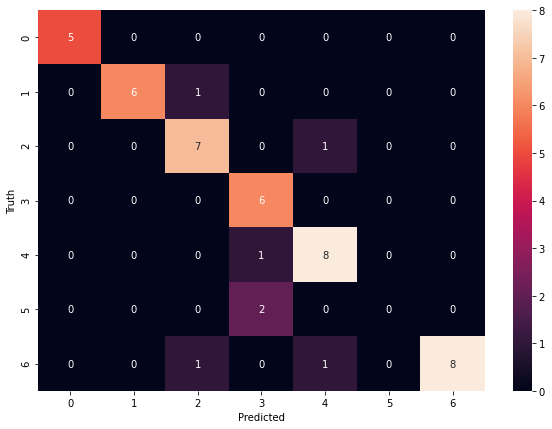

In [30]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
class_dict

{'Mary_Com': 0,
 'Mithali_Raj': 1,
 'MS_Dhoni': 2,
 'PV_Sindhu': 3,
 'Rahul_Dravis': 4,
 'Saina_Nehwal': 5,
 'Virat_Kohli': 6}

### Save the trained model

In [32]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


['saved_model.pkl']

### Save class dictionary

In [33]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))